In [2]:
# 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 필요한 모듈 불러오기

In [3]:
import os
import warnings
import time

import datetime          as dt
import matplotlib.pyplot as plt
import numpy             as np
import tensorflow        as tf
import pandas            as pd


from tensorflow.keras.layers     import Input, Dense, Dropout, GRU
from tensorflow.keras.losses     import categorical_crossentropy
from tensorflow.keras.models     import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils      import to_categorical
from tqdm                        import tqdm
from pathlib                     import Path

In [4]:
warnings.filterwarnings('ignore')

<div style = "height: 50px;"><div/>

# <span style = "font-weight:bold;color:#0172d4;">STEP 1</span> : 데이터 불러오기 및 전처리

In [5]:
data_path = Path('/content/drive/MyDrive/Colab Notebooks/ex17/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다.<br/>
그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

ating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

In [6]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

## Session Length

In [7]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [8]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [9]:
session_length.min(), session_length.max()

(20, 2314)

In [10]:
session_length.quantile(0.999)

1343.181000000005

In [11]:
long_session = session_length[session_length==200].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
406366,2438,908,3,974222921
406379,2438,2294,3,974222921
406412,2438,3812,5,974222921
406418,2438,3835,2,974222921
406427,2438,1186,4,974222921
...,...,...,...,...
406356,2438,3948,4,979792076
406461,2438,2502,4,981262001
406372,2438,1466,4,981322989
406413,2438,1131,5,987127691


In [12]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()

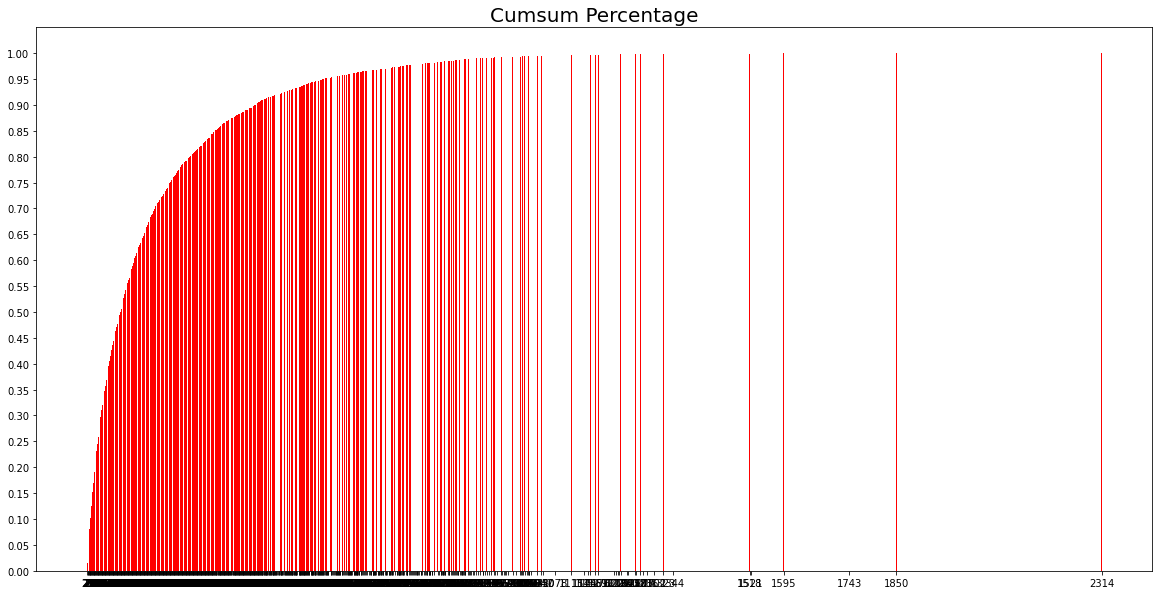

In [13]:
plt.figure(figsize=(20, 10))
plt.bar(x = length_percent_cumsum.index,
        height = length_percent_cumsum, 
        color='red')
plt.xticks(length_percent_cumsum.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage', size=20)
plt.show()

In [14]:
# 데이터 잘라내기
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]
length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

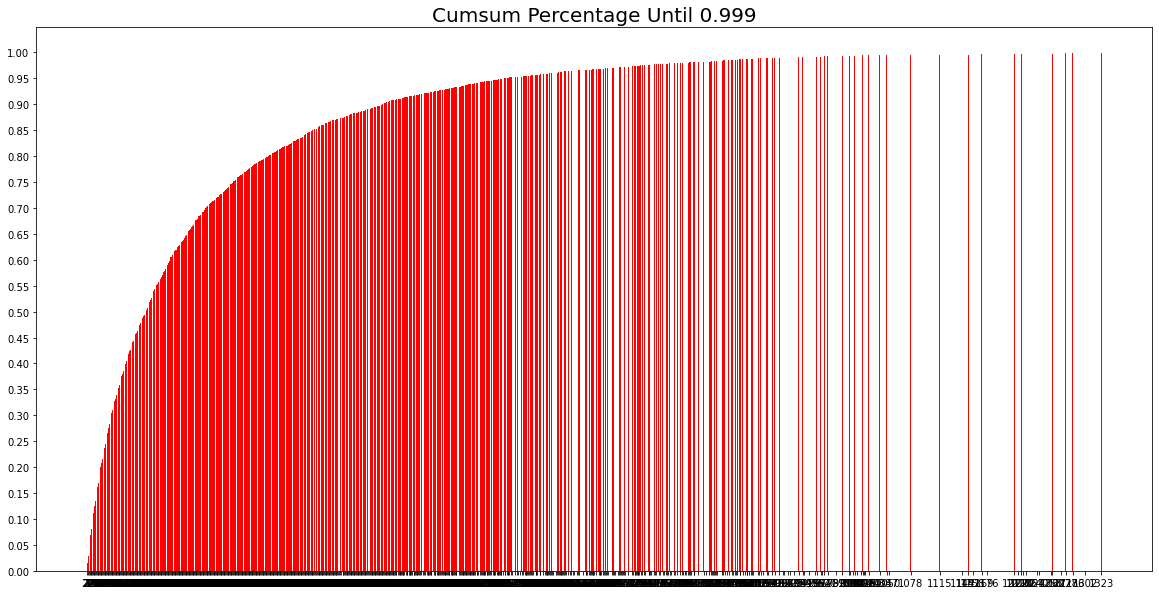

In [15]:
plt.figure(figsize=(20, 10))
plt.bar(x = length_percent_cumsum_999.index,
        height = length_percent_cumsum_999, 
        color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

## Session Tim

In [16]:
#  데이터의 시간 관련 정보를 확인
oldest, latest, mean = data['Time'].min(), data['Time'].max(), data['Time'].mean()
print(oldest) 
print(latest)
print(mean)

956703932
1046454590
972243695.4046655


In [17]:
type(latest)

numpy.int64

#### Time(UCT time)을 날짜 시간으로 변환

In [18]:
temp = time.time()

In [19]:
time.strftime('%Y-%m-%d', time.localtime((temp)))

'2022-07-03'

In [20]:
def time_to_localtime(time_values):
    time_values = time.strftime('%Y-%m-%d', time.localtime((time_values)))
    return time_values

In [21]:
data['Time'] = data['Time'].apply(time_to_localtime)

In [22]:
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31
22,1,1270,5,2000-12-31
27,1,1721,4,2000-12-31
37,1,1022,5,2000-12-31
24,1,2340,3,2000-12-31
...,...,...,...,...
1000019,6040,2917,4,2001-08-10
999988,6040,1921,4,2001-08-10
1000172,6040,1784,3,2001-08-10
1000167,6040,161,3,2001-08-10


UCT time: 1970년 1월 1일부터 경과된 초 단위<br/>
https://dojang.io/mod/page/view.php?id=2463

In [23]:
# timestamp로 변환
data['Time'] = data['Time'].apply(pd.Timestamp)

In [24]:
data['Time']

31        2000-12-31
22        2000-12-31
27        2000-12-31
37        2000-12-31
24        2000-12-31
             ...    
1000019   2001-08-10
999988    2001-08-10
1000172   2001-08-10
1000167   2001-08-10
1000042   2001-08-20
Name: Time, Length: 1000209, dtype: datetime64[ns]

## Data Cleansing

In [25]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [26]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31
22,1,1270,5,2000-12-31
27,1,1721,4,2000-12-31
37,1,1022,5,2000-12-31
24,1,2340,3,2000-12-31
...,...,...,...,...
1000019,6040,2917,4,2001-08-10
999988,6040,1921,4,2001-08-10
1000172,6040,1784,3,2001-08-10
1000167,6040,161,3,2001-08-10


## Train / Valid / Test split

In [27]:
data['Time'].min(), data['Time'].max()

(Timestamp('2000-04-25 00:00:00'), Timestamp('2003-02-28 00:00:00'))

In [28]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time        = data["Time"].max()
    session_last_time = data.groupby("UserId")["Time"].max()
    session_in_train  = session_last_time[session_last_time <  final_time - dt.timedelta(n_days)].index
    session_in_test   = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index
    
    before_date       = data[data["UserId"].isin(session_in_train)]
    after_date        = data[data["UserId"].isin(session_in_test)]
    after_date        = after_date[after_date["ItemId"].isin(before_date["ItemId"])]
    return before_date, after_date

In [29]:
tr, test = split_by_date(data, n_days = 30)
tr, val = split_by_date(tr, n_days = 30)

In [30]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t UserId: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [31]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 917122
	 UserId: 5852
	 Items: 3416
	 First Time : 2000-04-25 00:00:00
	 Last Time : 2002-12-28 00:00:00

* valid Set Stats Info
	 Events: 30241
	 UserId: 82
	 Items: 2961
	 First Time : 2000-05-05 00:00:00
	 Last Time : 2003-01-28 00:00:00

* test Set Stats Info
	 Events: 52248
	 UserId: 106
	 Items: 3175
	 First Time : 2000-05-01 00:00:00
	 Last Time : 2003-02-28 00:00:00



In [32]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [33]:
# 전처리한 데이터를 저장
tr.to_pickle('/content/drive/MyDrive/Colab Notebooks/ex17/data/ex_data/train.pkl')
val.to_pickle('/content/drive/MyDrive/Colab Notebooks/ex17/data/ex_data/valid.pkl')
test.to_pickle('/content/drive/MyDrive/Colab Notebooks/ex17/data/ex_data/test.pkl')

# <span style = "font-weight:bold;color:#0172d4;">STEP 4</span> : Data Pipeline

## 4.1 SessionDataset

In [34]:
# 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [35]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31,0
22,1,1270,5,2000-12-31,1
27,1,1721,4,2000-12-31,2
37,1,1022,5,2000-12-31,3
24,1,2340,3,2000-12-31,4
36,1,1836,5,2000-12-31,5
3,1,3408,4,2000-12-31,6
7,1,2804,5,2000-12-31,7
47,1,1207,4,2000-12-31,8
0,1,1193,5,2000-12-31,9


In [36]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 916658, 916781, 917122], dtype=int32)

In [37]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5849, 5850, 5851])

# 4.2 SessionDataLoader

In [38]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size = 50):
        self.dataset    = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize() # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1 # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp    = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        # 첫 배치에 사용할 세션 Index를 가져온다.
        first_iters  = np.arange(self.batch_size)
        # 마지막으로 다루고 있는 세션 Index를 저장해둔다.
        last_session = self.batch_size - 1    
        # data 상에서 session이 시작된 위치를 가져온다.
        start        = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]
        # session이 끝난 위치 바로 다음 위치를 가져온다.
        end          = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]
        # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것이다.
        mask         = np.array([])
        # data를 전부 돌았는지 기록하기 위한 변수이다.
        finished     = False
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update한다.
        
        start += min_len # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해준다.
        mask   = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻이다. mask에 기록해준다.

        for i, idx in enumerate(mask, start = 1): # mask에 추가된 세션 개수만큼 새로운 세션을 돌것이다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]: # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것이다.
                finished = True
                break
            # update the next starting / ending point
            # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]
            end[idx]   = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask) # 마지막 세션의 위치를 기록해둔다.
        return start, end, mask, last_session, finished

In [39]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(2)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31,0
22,1,1270,5,2000-12-31,1


In [40]:
iter_ex = iter(tr_data_loader)

In [41]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


# <span style = "font-weight:bold;color:#0172d4;">STEP 5</span> : Modeling

## 5.1 Evaluation Metric - 모델 성능 평가를 위한 지표

In [42]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## 5.2 Model Architecture -  모델 구조를 구현

In [43]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [44]:
# 모델에 사용할 hyper-parameter를 class형식으로 관리
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=44, hsz=50, drop_rate=0.1, lr=0.01, epochs=20, k=20)

In [45]:
model = create_model(args)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(44, 1, 3416)]           0         
                                                                 
 GRU (GRU)                   [(44, 50),                520200    
                              (44, 50)]                          
                                                                 
 dropout (Dropout)           (44, 50)                  0         
                                                                 
 dense (Dense)               (44, 3416)                174216    
                                                                 
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


## 5.3 Model Training

In [46]:
# train 셋으로 학습하면서 valid 셋으로 검증한다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader  = SessionDataLoader(train_dataset, batch_size = args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr["UserId"].nunique()
        tr_loader  = tqdm(train_loader, total = total_step // args.batch_size, desc = "Train", mininterval = 1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화한다. 아래 메서드에서 확인해주세요.

            input_ohe  = to_categorical(feat, num_classes = args.num_items)
            input_ohe  = np.expand_dims(input_ohe, axis = 1)
            target_ohe = to_categorical(target, num_classes = args.num_items)

            result     = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss = result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증한다.

        print(f"\t - Recall@{args.k} epoch {epoch} : {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch} : {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer     = model.get_layer(name = "GRU") # model에서 gru layer를 가져온다.cal(feat, num_classes = args.num_items)
            input_ohe  = np.expand_dims(input_ohe, axis = 1)
            target_ohe = to_categoric
    hidden_states = gru_layer.states[0].numpy()   # gru_layer의 parameter를 가져온다.
    for elt in mask:                              # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0                 # parameter를 초기화한다.
    gru_layer.reset_states(states = hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드이다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있다.
    dataset = SessionDataset(data)
    loader  = SessionDataLoader(dataset, batch_size = args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data["UserId"].nunique()
    for inputs, label, mask in tqdm(loader, total = total_step // args.batch_size, desc = "Evaluation", mininterval = 1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes = args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis = 1)

        pred      = model.predict(input_ohe, batch_size = args.batch_size)
        pred_arg  = tf.argsort(pred, direction = "DESCENDING") # softmax 값이 큰 순서대로 sorting 한다.

        length    = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [47]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
train_model(model, args)

# # # 학습된 모델을 불러옵니다.
# model = tf.keras.models.load_model('data/trained_model')

Evaluation:  60%|█████▉    | 409/685 [02:09<01:27,  3.16it/s]


	 - Recall@20 epoch 1 : 0.225995
	 - MRR@20    epoch 1 : 0.058120



Evaluation:  60%|█████▉    | 409/685 [02:09<01:27,  3.17it/s]


	 - Recall@20 epoch 2 : 0.227328
	 - MRR@20    epoch 2 : 0.059438



Evaluation:  60%|█████▉    | 409/685 [02:09<01:27,  3.17it/s]


	 - Recall@20 epoch 3 : 0.230662
	 - MRR@20    epoch 3 : 0.060794



Evaluation:  60%|█████▉    | 409/685 [02:08<01:26,  3.18it/s]


	 - Recall@20 epoch 4 : 0.226439
	 - MRR@20    epoch 4 : 0.059087



Evaluation:  60%|█████▉    | 409/685 [02:08<01:26,  3.18it/s]


	 - Recall@20 epoch 5 : 0.228384
	 - MRR@20    epoch 5 : 0.060019



Evaluation:  60%|█████▉    | 409/685 [02:08<01:26,  3.19it/s]


	 - Recall@20 epoch 6 : 0.230829
	 - MRR@20    epoch 6 : 0.060913



Evaluation:  60%|█████▉    | 409/685 [02:08<01:26,  3.19it/s]


	 - Recall@20 epoch 7 : 0.235219
	 - MRR@20    epoch 7 : 0.061391



Evaluation:  60%|█████▉    | 409/685 [02:08<01:26,  3.19it/s]


	 - Recall@20 epoch 8 : 0.231607
	 - MRR@20    epoch 8 : 0.061100



Evaluation:  60%|█████▉    | 409/685 [02:07<01:26,  3.20it/s]


	 - Recall@20 epoch 9 : 0.233441
	 - MRR@20    epoch 9 : 0.061384



Evaluation:  60%|█████▉    | 409/685 [02:08<01:26,  3.19it/s]


	 - Recall@20 epoch 10 : 0.231996
	 - MRR@20    epoch 10 : 0.061473



Evaluation:  60%|█████▉    | 409/685 [02:09<01:27,  3.16it/s]


	 - Recall@20 epoch 11 : 0.233107
	 - MRR@20    epoch 11 : 0.060074



Evaluation:  60%|█████▉    | 409/685 [02:08<01:26,  3.18it/s]


	 - Recall@20 epoch 12 : 0.231774
	 - MRR@20    epoch 12 : 0.061231



Evaluation:  60%|█████▉    | 409/685 [02:09<01:27,  3.17it/s]


	 - Recall@20 epoch 13 : 0.233218
	 - MRR@20    epoch 13 : 0.060783



Evaluation:  60%|█████▉    | 409/685 [02:08<01:26,  3.17it/s]


	 - Recall@20 epoch 14 : 0.229218
	 - MRR@20    epoch 14 : 0.060384



Evaluation:  60%|█████▉    | 409/685 [02:09<01:27,  3.16it/s]


	 - Recall@20 epoch 15 : 0.228551
	 - MRR@20    epoch 15 : 0.060456



Evaluation:  60%|█████▉    | 409/685 [02:08<01:27,  3.17it/s]


	 - Recall@20 epoch 16 : 0.231329
	 - MRR@20    epoch 16 : 0.061130



Evaluation:  60%|█████▉    | 409/685 [02:08<01:27,  3.17it/s]


	 - Recall@20 epoch 17 : 0.230440
	 - MRR@20    epoch 17 : 0.060784



Evaluation:  60%|█████▉    | 409/685 [02:09<01:27,  3.17it/s]


	 - Recall@20 epoch 18 : 0.232163
	 - MRR@20    epoch 18 : 0.061132



Evaluation:  60%|█████▉    | 409/685 [02:09<01:27,  3.17it/s]


	 - Recall@20 epoch 19 : 0.233552
	 - MRR@20    epoch 19 : 0.060681



Evaluation:  60%|█████▉    | 409/685 [02:08<01:26,  3.18it/s]

	 - Recall@20 epoch 20 : 0.235219
	 - MRR@20    epoch 20 : 0.061587



In [48]:
args.val.head(11)

,UserId,ItemId,Rating,Time,item_idx
8827,59,260,3,2000-12-27,11
8875,59,3688,1,2000-12-27,704
8736,59,902,4,2000-12-27,93
8813,59,2728,3,2000-12-27,90
8907,59,1246,3,2000-12-27,29
8698,59,1250,4,2000-12-27,219
8851,59,2858,3,2000-12-27,62
8884,59,2966,4,2000-12-27,406
8697,59,1249,3,2000-12-27,1234
8762,59,1466,2,2000-12-27,339


## 5.4 Inference - 성능검증

In [49]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  72%|███████▏  | 855/1185 [04:33<01:45,  3.13it/s]

	 - Recall@20: 0.211350
	 - MRR@20: 0.054723



# <span style = "font-weight:bold;color:#0172d4;">STEP 1</span> : 들어가며

## 1. 조건
<hr/>

### 소제목

<div style = "height: 50px;"></div>

## 회고
<hr/>

# 참고 링크

<ul>
    <li style = "margin-bottom:14px;"><a href = ""></a></li>
    <li style = "margin-bottom:14px;"><a href = ""></a></li>
    <li style = "margin-bottom:14px;"><a href = ""></a></li>
    <li style = "margin-bottom:14px;"><a href = ""></a></li>
    <li style = "margin-bottom:14px;"><a href = ""></a></li>
</ul>